## Archetype Analysis on MNIST (10 Runs Stability)
#### - Compare AAnet vs Linear AA (10 runs)
#### - Metrics: Normalized Mutual Information (NMI), Archetype Consistency, ISI
#### - Visualizations: Archetypes, UMAP assignments, reconstructions, simplex

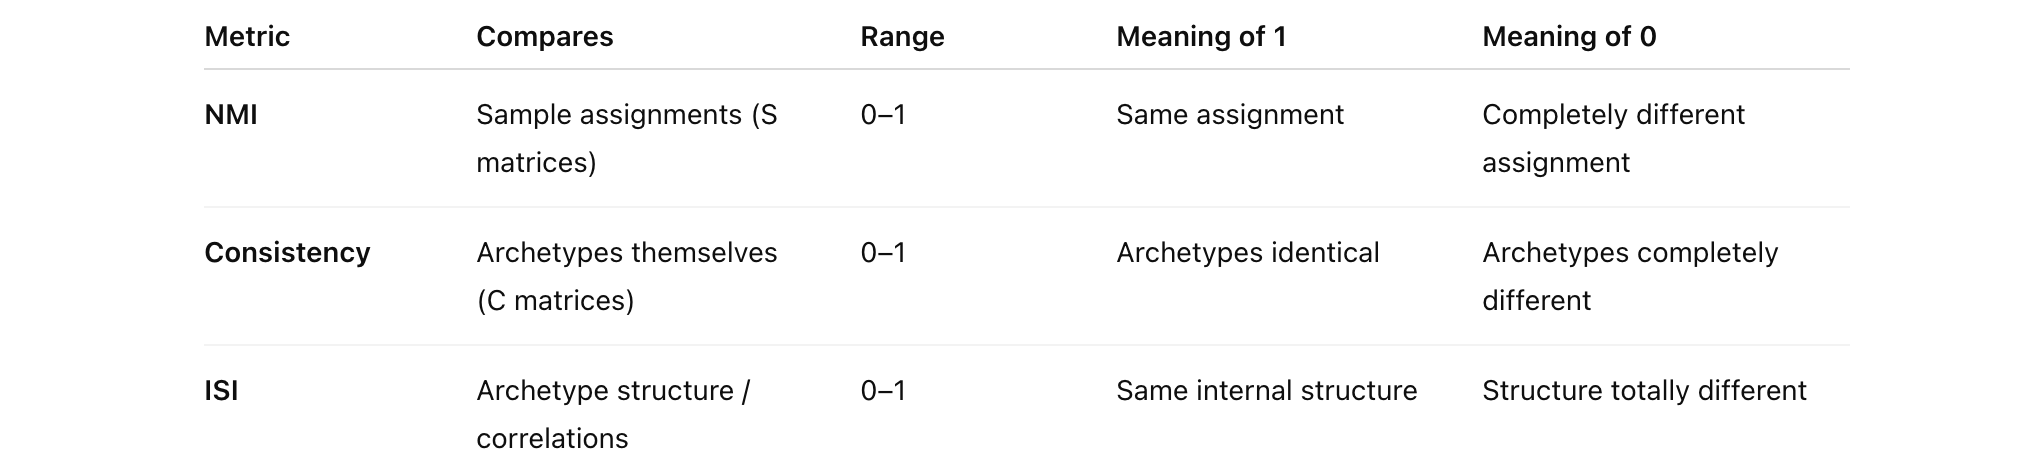

In [6]:

# %% [markdown]
# # Archetype Analysis on MNIST
# Comparing archetypes from AAnet, MIDA, and Linear AA.

# %% 
import os
import numpy as np
import torch
from scipy.spatial.distance import pdist, squareform
from scipy.stats import entropy
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from torchvision import datasets, transforms
import umap
from itertools import combinations

import seaborn as sns
# --- Configuration ---
N_ARCHETYPES = 3
N_SAMPLES = 5842
N_PROTOTYPES = 20
IMG_SHAPE = (28, 28)
N_RUNS = 10
N_RUNS_AANET = 5

# Paths
LINEAR_AA_PATH = 'LinearAA/Python/mnist_gaussian_aa_results.pth'
AANET_PATH = '/Users/joaomata/Desktop/DTU/DeepLearning/ProjectDL/AAnet/example_notebooks/results/AAnet_10runs_mnist/AAnet_10runs.pth'
SAVE_DIR = "analysis_results/mnist"
os.makedirs(SAVE_DIR, exist_ok=True)


In [7]:
# --- Helper Functions ---

def to_numpy(tensor):
    if isinstance(tensor, torch.Tensor):
        return tensor.detach().cpu().numpy()
    return tensor

def preprocess(X):
    meanX = np.mean(X, axis=0)
    X_centered = X - meanX
    mSST = np.sum(np.mean(X_centered**2, axis=0))
    return X_centered, mSST

def calcMI(z1, z2):
    eps = 1e-16
    P = z1 @ z2.T
    PXY = P / P.sum()
    PXPY = np.outer(PXY.sum(1), PXY.sum(0))
    return np.sum(PXY * np.log(eps + PXY / (eps + PXPY)))

def calcNMI(z1, z2):
    return 2 * calcMI(z1, z2) / (calcMI(z1, z1) + calcMI(z2, z2))

def ArchetypeConsistency(XC1, XC2, mSST):
    D = squareform(pdist(np.hstack((XC1, XC2)).T, 'euclidean'))**2
    D = D[:XC1.shape[1], XC1.shape[1]:]
    
    i, j, v = [], [], []
    D_temp = D.copy()
    for k in range(XC1.shape[1]):
        min_index = np.unravel_index(np.argmin(D_temp, axis=None), D_temp.shape)
        i.append(min_index[0])
        j.append(min_index[1])
        v.append(D[i[-1], j[-1]])
        D_temp[i[-1], :] = np.inf
        D_temp[:, j[-1]] = np.inf
        
    consistency = 1 - np.mean(v) / mSST
    D2 = np.abs(np.corrcoef(np.hstack((XC1, XC2)).T))[:XC1.shape[1], XC1.shape[1]:]
    ISI = 1 / (2 * XC1.shape[1] * (XC1.shape[1]-1)) * \
          (np.sum(D2/np.max(D2, axis=1, keepdims=True) + D2/np.max(D2, axis=0, keepdims=True)) - 2*XC1.shape[1])
    return consistency, ISI


In [8]:
# --- Load MNIST data (digit 4) ---
mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
mask = mnist.targets == 4
indices = torch.where(mask)[0][:N_SAMPLES]

X_raw = mnist.data[indices].float() / 255
X_raw = X_raw.flatten(1).numpy()
X_tensor = torch.from_numpy(X_raw).t().double()


## Analyse Metrics Across Runs 

In [9]:
# --- Load Linear AA 10 runs ---
checkpoint = torch.load(LINEAR_AA_PATH)
S_list = checkpoint['S']  # list of 10 runs
C_list = checkpoint['C']  # list of 10 runs
L_list = checkpoint['L']  # list of 10 losses

# Convert to numpy if tensors
S_list = [to_numpy(s) for s in S_list]
C_list = [to_numpy(c) for c in C_list]

# --- Load AAnet 10 runs ---
checkpoint_aanet = torch.load(AANET_PATH, map_location='cpu')
S_aanet_list = checkpoint_aanet['S_list']  # list of 10 runs
C_aanet_list = checkpoint_aanet['C_list']  # list of 10 runs
X_aanet = checkpoint_aanet['X']            # last X_scaled

# Convert to numpy if tensors
S_aanet_list = [s if isinstance(s, np.ndarray) else s.numpy() for s in S_aanet_list]
C_aanet_list = [c if isinstance(c, np.ndarray) else c.numpy() for c in C_aanet_list]


/var/folders/cz/_btxbwrj7cx6d5v2vzg25g740000gn/T/ipykernel_15073/885528536.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(LINEAR_AA_PATH)
/var/f

In [10]:
from itertools import combinations
import numpy as np

def compute_stability_metrics(S_list, C_list, X_raw, N_RUNS):
    """
    Compute pairwise stability metrics across runs.
    
    Returns:
        nmi_matrix, consistency_matrix, isi_matrix
    """
    X_centered, mSST_val = preprocess(X_raw)

    nmi_matrix = np.zeros((N_RUNS, N_RUNS))
    consistency_matrix = np.zeros((N_RUNS, N_RUNS))
    isi_matrix = np.zeros((N_RUNS, N_RUNS))

    for i, j in combinations(range(N_RUNS), 2):
        S_i, S_j = S_list[i], S_list[j]
        C_i, C_j = C_list[i], C_list[j]

        nmi_matrix[i, j] = calcNMI(S_i, S_j)
        consistency_matrix[i, j], isi_matrix[i, j] = ArchetypeConsistency(C_i, C_j, mSST_val)

    # Fill symmetric and diagonal
    nmi_matrix += nmi_matrix.T
    consistency_matrix += consistency_matrix.T
    isi_matrix += isi_matrix.T
    np.fill_diagonal(nmi_matrix, 1)
    np.fill_diagonal(consistency_matrix, 1)
    np.fill_diagonal(isi_matrix, 1)

    return nmi_matrix, consistency_matrix, isi_matrix


# --- Compute for Linear AA ---
nmi_linear, consistency_linear, isi_linear = compute_stability_metrics(S_list, C_list, X_raw, N_RUNS)

print("Linear AA 10-run stability:")
print("Mean NMI:", np.mean(nmi_linear[np.triu_indices(N_RUNS, 1)]))
print("Mean Archetype Consistency:", np.mean(consistency_linear[np.triu_indices(N_RUNS, 1)]))
print("Mean ISI:", np.mean(isi_linear[np.triu_indices(N_RUNS, 1)]))


# --- Compute for AAnet ---
N_RUNS_AANET = len(S_aanet_list)
nmi_aanet, consistency_aanet, isi_aanet = compute_stability_metrics(S_aanet_list, C_aanet_list, X_raw, N_RUNS_AANET)

print("AAnet stability ({} runs):".format(N_RUNS_AANET))
print("Mean NMI:", np.mean(nmi_aanet[np.triu_indices(N_RUNS_AANET, 1)]))
print("Mean Archetype Consistency:", np.mean(consistency_aanet[np.triu_indices(N_RUNS_AANET, 1)]))
print("Mean ISI:", np.mean(isi_aanet[np.triu_indices(N_RUNS_AANET, 1)]))




Linear AA 10-run stability:
Mean NMI: 0.9658223100903225
Mean Archetype Consistency: 0.999565324731182
Mean ISI: 0.029044937893802657
AAnet stability (5 runs):
Mean NMI: 0.8688531219959259
Mean Archetype Consistency: 0.4425170233074314
Mean ISI: 0.5172576915689495


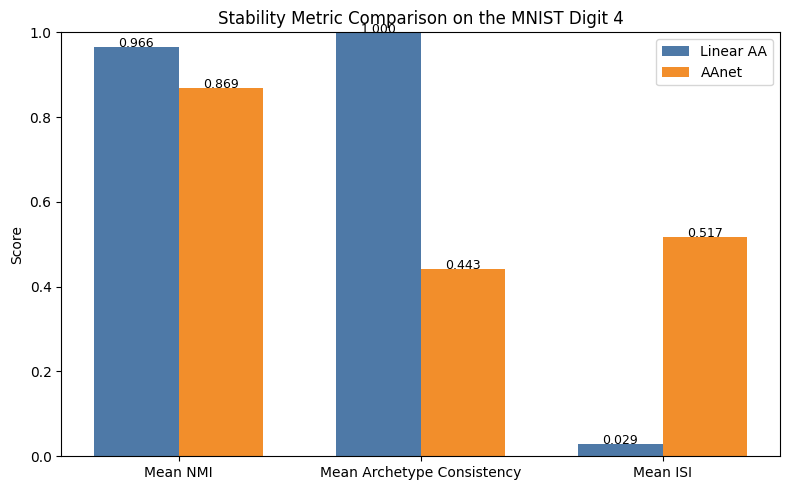

In [11]:

import matplotlib.pyplot as plt
import numpy as np

# Compute mean metrics from already computed matrices
metrics_linear = [
    np.mean(nmi_linear[np.triu_indices(N_RUNS, 1)]),
    np.mean(consistency_linear[np.triu_indices(N_RUNS, 1)]),
    np.mean(isi_linear[np.triu_indices(N_RUNS, 1)])
]

metrics_aanet = [
    np.mean(nmi_aanet[np.triu_indices(N_RUNS_AANET, 1)]),
    np.mean(consistency_aanet[np.triu_indices(N_RUNS_AANET, 1)]),
    np.mean(isi_aanet[np.triu_indices(N_RUNS_AANET, 1)])
]

names = ['Mean NMI', 'Mean Archetype Consistency', 'Mean ISI']
x = np.arange(len(names))
width = 0.35

fig, ax = plt.subplots(figsize=(8,5))
bars1 = ax.bar(x - width/2, metrics_linear, width, label='Linear AA', color='#4e79a7')
bars2 = ax.bar(x + width/2, metrics_aanet, width, label='AAnet', color='#f28e2b')

# Add numeric labels on top
for bars in [bars1, bars2]:
    for bar in bars:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                f"{bar.get_height():.3f}", ha='center', fontsize=9)

ax.set_ylabel('Score')
ax.set_title('Stability Metric Comparison on the MNIST Digit 4')
ax.set_xticks(x)
ax.set_xticklabels(names)
ax.set_ylim(0, 1)
ax.legend()
plt.tight_layout()
# save
plt.savefig(os.path.join(SAVE_DIR, 'stability_metric_comparison.png'), dpi=300)
plt.show()


**Mean NMI: 0.966** → very high, meaning the archetypal coefficients 
𝑆
S are very consistent across runs.

**Mean Archetype Consistency**: 0.9996 → extremely high, meaning the archetypes 
𝐶
C themselves are almost identical across runs.

**Mean ISI: 0.029** → low, meaning the identity/similarity structure of archetypes is very stable.

---


## Analysing the Archetypes (select 1 run)

In [9]:
# --- Select archetypes to visualize ---
# Example: take the first run
C_linear = C_list[0]
S_linear = S_list[0]

C_aanet = C_aanet_list[0]
S_aanet = S_aanet_list[0]

In [10]:
# --- Load Linear AA 10 runs ---
checkpoint = torch.load(LINEAR_AA_PATH)
S_list = checkpoint['S']  # list of 10 runs
C_list = checkpoint['C']  # list of 10 runs
L_list = checkpoint['L']  # list of 10 losses

# Convert to numpy if tensors
S_list = [to_numpy(s) for s in S_list]
C_list = [to_numpy(c) for c in C_list]

# ✅ FIX: Transpose Linear AA matrices to match AAnet convention
# Linear AA convention: C is (N_samples, K), S is (K, N_samples)
# AAnet convention: C is (N_features, K), S is (K, N_samples)
# We need C to be (N_features, K) for archetypes
C_list = [X_raw.T @ c for c in C_list]  # Transform: (784, 5842) @ (5842, 3) = (784, 3)
# S stays the same - already (3, 5842)

# --- Load AAnet 10 runs ---
checkpoint_aanet = torch.load(AANET_PATH, map_location='cpu')
S_aanet_list = checkpoint_aanet['S_list']
C_aanet_list = checkpoint_aanet['C_list']
X_aanet = checkpoint_aanet['X']

# Convert to numpy if tensors
S_aanet_list = [s if isinstance(s, np.ndarray) else s.numpy() for s in S_aanet_list]
C_aanet_list = [c if isinstance(c, np.ndarray) else c.numpy() for c in C_aanet_list]

/var/folders/cz/_btxbwrj7cx6d5v2vzg25g740000gn/T/ipykernel_9379/2981259068.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(LINEAR_AA_PATH)
/var/f

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from scipy.stats import entropy

def to_numpy(tensor):
    """Convert tensor to numpy array if needed."""
    if isinstance(tensor, torch.Tensor):
        return tensor.detach().cpu().numpy()
    return tensor

def plot_archetypes(C, img_shape=(28, 28), title="Archetypes", cmap='gray_r', save_name=None):
    """
    Plots the archetypes (columns of C) as images.
    
    Args:
        C: np.array or torch.Tensor, shape (n_features, n_archetypes)
        img_shape: tuple, e.g., (28, 28)
        title: figure title
        cmap: colormap for images
        save_name: filename to save the figure (optional)
    """
    C = to_numpy(C)
    n_archetypes = C.shape[1]
    
    fig, axes = plt.subplots(1, n_archetypes, figsize=(2 * n_archetypes, 3))
    if n_archetypes == 1:
        axes = [axes]
    
    for i in range(n_archetypes):
        img = C[:, i].reshape(img_shape)
        axes[i].imshow(img, cmap=cmap, vmin=0, vmax=1)
        axes[i].axis('off')
        axes[i].set_title(f'Arc {i+1}')
    
    plt.suptitle(title, fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.85])
    
    if save_name is not None:
        os.makedirs(os.path.dirname(save_name), exist_ok=True)
        plt.savefig(save_name, bbox_inches='tight')
        print(f"Saved figure to: {save_name}")
        plt.show()

def plot_umap_assignment(X_umap, S, title="Sample Assignment", s=5, alpha=0.6, save_name=None):
    """
    Plots UMAP embedding colored by dominant archetype assignment.
    
    Args:
        X_umap: np.array, shape (N_samples, 2) -> UMAP 2D embedding
        S: np.array or torch.Tensor, shape (k, N_samples) -> Archetype coefficients
        title: figure title
        s: marker size
        alpha: marker transparency
        save_name: optional filename to save figure
    """
    S = to_numpy(S)
    dominant_arc = np.argmax(S, axis=0)  # ✅ FIXED: axis=0 for (K, N) shape
    n_arc = S.shape[0]
    
    fig, ax = plt.subplots(figsize=(8, 8))
    scatter = ax.scatter(
        X_umap[:, 0],
        X_umap[:, 1],
        c=dominant_arc,
        cmap='viridis',
        s=s,
        alpha=alpha
    )
    
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('UMAP 1')
    ax.set_ylabel('UMAP 2')
    
    cbar = plt.colorbar(scatter, ax=ax, ticks=np.arange(n_arc), boundaries=np.arange(n_arc + 1) - 0.5)
    cbar.set_ticklabels([f'Arc {i+1}' for i in range(n_arc)])
    
    if save_name is not None:
        os.makedirs(os.path.dirname(save_name), exist_ok=True)
        plt.savefig(save_name, bbox_inches='tight')
        print(f"Saved figure to: {save_name}")
        plt.show()

def plot_reconstruction(X, C, S, n_samples=5, img_shape=(28,28), title="Reconstruction Quality Check", save_name=None):
    """
    Visualizes random samples side-by-side with their reconstructions.
    
    Args:
        X: (N_samples, n_features) original data
        C: (n_features, k) archetype matrix
        S: (k, N_samples) coefficient matrix
        n_samples: number of random samples to show
        img_shape: reshape for visualization
        title: figure title
        save_name: optional path to save figure
    """
    X = to_numpy(X)
    C = to_numpy(C)
    S = to_numpy(S)
    
    X_rec = (C @ S).T  # ✅ FIXED: (784, 3) @ (3, N) = (784, N) -> transpose to (N, 784)
    indices = np.random.choice(X.shape[0], n_samples, replace=False)
    
    fig, axes = plt.subplots(2, n_samples, figsize=(2*n_samples, 4))
    
    for i, idx in enumerate(indices):
        axes[0,i].imshow(X[idx].reshape(img_shape), cmap='gray_r')
        axes[0,i].axis('off')
        if i==0: axes[0,i].set_title("Original", x=-0.5, ha='right')
        
        rec = np.clip(X_rec[idx].reshape(img_shape), 0, 1)
        axes[1,i].imshow(rec, cmap='gray_r')
        axes[1,i].axis('off')
        if i==0: axes[1,i].set_title("Reconstructed", x=-0.5, ha='right')
    
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    
    if save_name is not None:
        os.makedirs(os.path.dirname(save_name), exist_ok=True)
        plt.savefig(save_name, bbox_inches='tight')
        print(f"Saved figure to: {save_name}")
        plt.show()

def plot_simplex(S, C, img_shape=(28,28), title="Simplex Analysis", cmap='gray_r', save_name=None):
    """
    Plots samples in a Barycentric (triangle) projection with archetypes at vertices.
    Only works for k=3.
    
    Args:
        S: (k, N_samples) coefficient matrix
        C: (n_features, k) archetype matrix
        img_shape: tuple for reshaping archetype images
        title: figure title
        cmap: colormap for images
        save_name: optional path to save figure
    """
    S = to_numpy(S)
    C = to_numpy(C)
    k, N = S.shape
    if k != 3:
        print(f"⚠️ Simplex plot requires k=3, got k={k}. Skipping plot.")
        return
    
    # Convert to 2D simplex coordinates
    S_cells = S.T  # (N, 3)
    x = S_cells[:, 1] + 0.5 * S_cells[:, 2]
    y = (np.sqrt(3)/2) * S_cells[:, 2]
    X_simplex = np.column_stack([x, y])
    
    # Vertex positions
    vertices = np.array([[0,0], [1,0], [0.5, np.sqrt(3)/2]])
    centroid = vertices.mean(axis=0)
    
    # Mixing strength (entropy)
    mix_strength = np.array([entropy(S_cells[i]) for i in range(N)])
    mix_strength = np.where(np.isfinite(mix_strength), mix_strength, 0)
    mix_strength /= np.log(k)
    
    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
    fig.suptitle(title, fontsize=16, fontweight='bold')
    
    # Left: simplex scatter
    scatter = ax1.scatter(X_simplex[:,0], X_simplex[:,1], c=mix_strength, cmap='RdYlGn_r', s=10, alpha=0.6, edgecolors='none', vmin=0, vmax=1)
    triangle = plt.Polygon(vertices, fill=False, edgecolor='black', linewidth=2, zorder=0)
    ax1.add_patch(triangle)
    
    # Add archetype images at vertices
    for i in range(k):
        img = C[:,i].reshape(img_shape)
        im_box = OffsetImage(img, zoom=2.0, cmap=cmap)
        ab = AnnotationBbox(im_box, vertices[i], frameon=True, bboxprops=dict(edgecolor='red', linewidth=2))
        ax1.add_artist(ab)
    
    ax1.set_xlim(-0.3, 1.3)
    ax1.set_ylim(-0.3, 1.1)
    ax1.axis('off')
    ax1.set_aspect('equal')
    cbar = plt.colorbar(scatter, ax=ax1, orientation='vertical', fraction=0.03, pad=0.04)
    cbar.set_label('Mixing Strength (Normalized Entropy)')
    
    # Right: histogram of mixing strength
    ax2.hist(mix_strength, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
    mean_mix = mix_strength.mean()
    ax2.axvline(mean_mix, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_mix:.2f}')
    ax2.set_title('Distribution of Mixing Strength')
    ax2.set_xlabel('Mixing Strength (0=Pure, 1=Mixed)')
    ax2.set_ylabel('Count')
    ax2.legend()
    ax2.grid(alpha=0.3)
    
    plt.tight_layout(rect=[0,0,1,0.95])
    
    if save_name is not None:
        os.makedirs(os.path.dirname(save_name), exist_ok=True)
        plt.savefig(save_name, bbox_inches='tight')
        print(f"Saved figure to: {save_name}")
        plt.show()

/opt/anaconda3/envs/sae_env/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Saved figure to: analysis_results/mnist/linear_aa_archetypes_run1.png


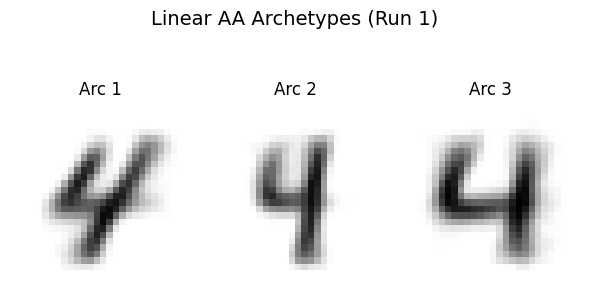

Saved figure to: analysis_results/mnist/linear_aa_umap_run1.png


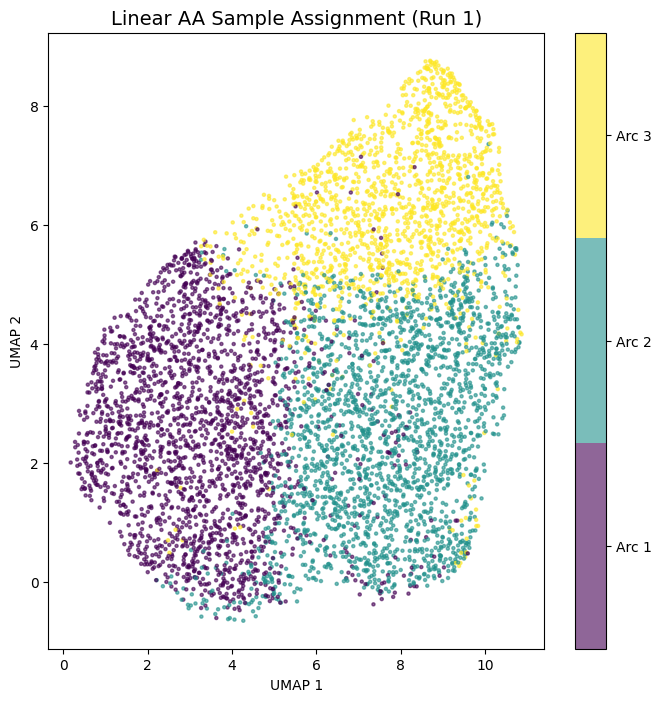

Saved figure to: analysis_results/mnist/linear_aa_reconstruction_run1.png


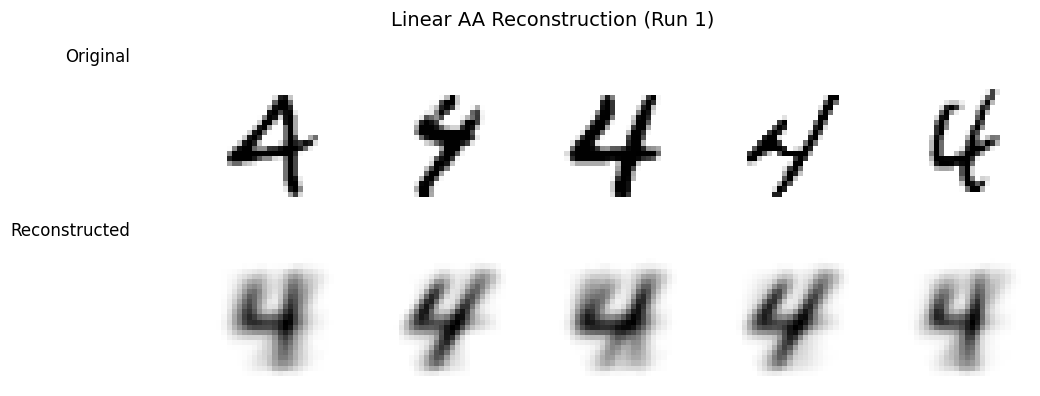

Saved figure to: analysis_results/mnist/linear_aa_simplex_run1.png


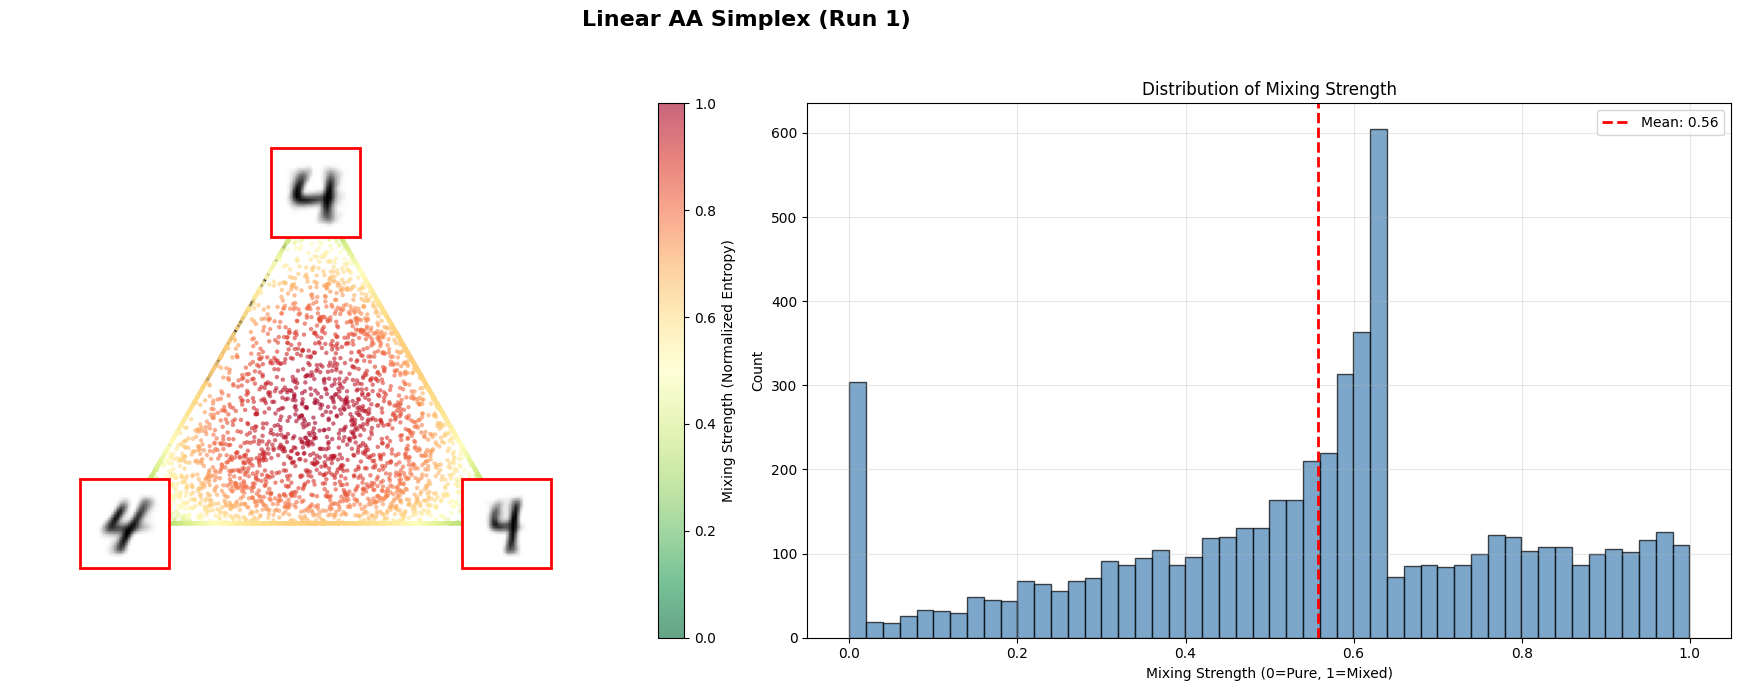

Saved figure to: analysis_results/mnist/aanet_archetypes_run1.png


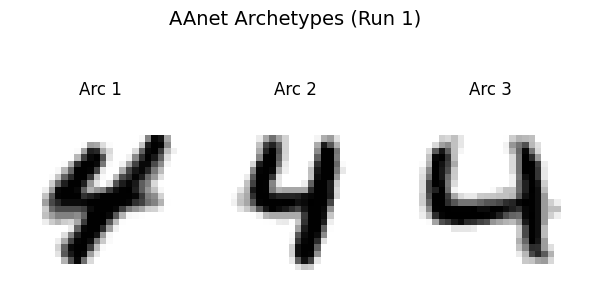

Saved figure to: analysis_results/mnist/aanet_umap_run1.png


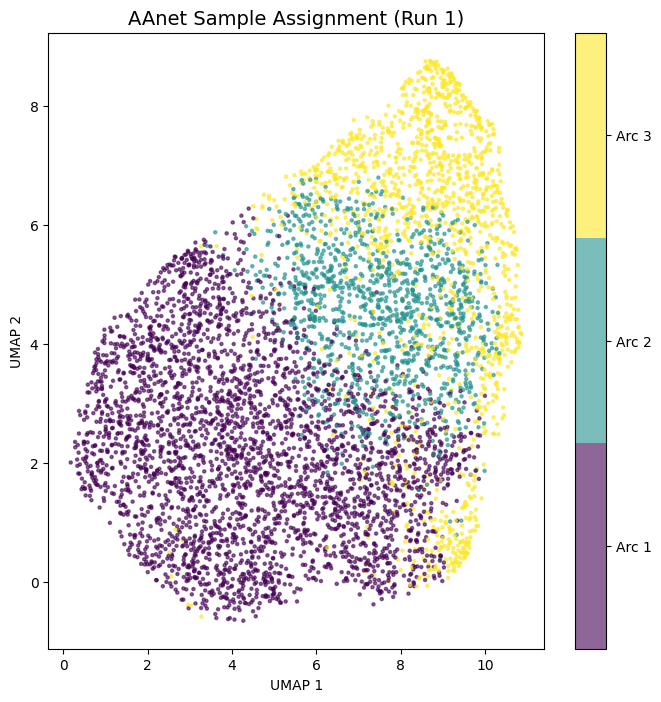

Saved figure to: analysis_results/mnist/aanet_reconstruction_run1.png


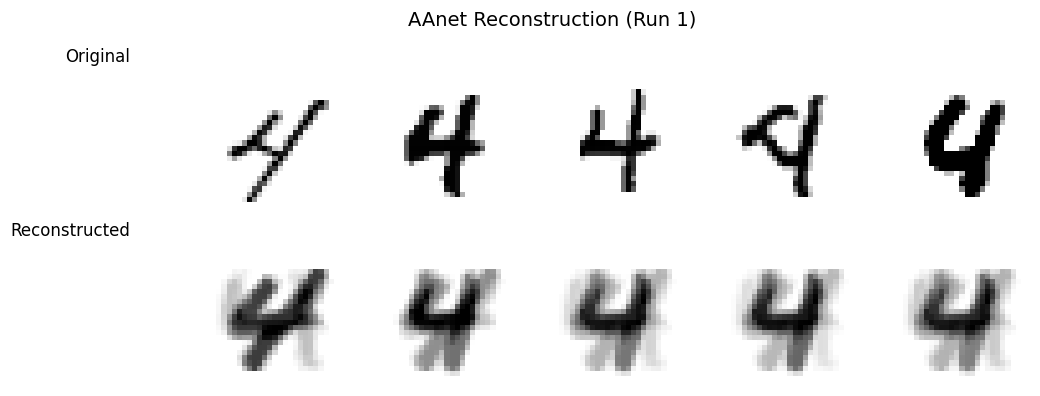

Saved figure to: analysis_results/mnist/aanet_simplex_run1.png


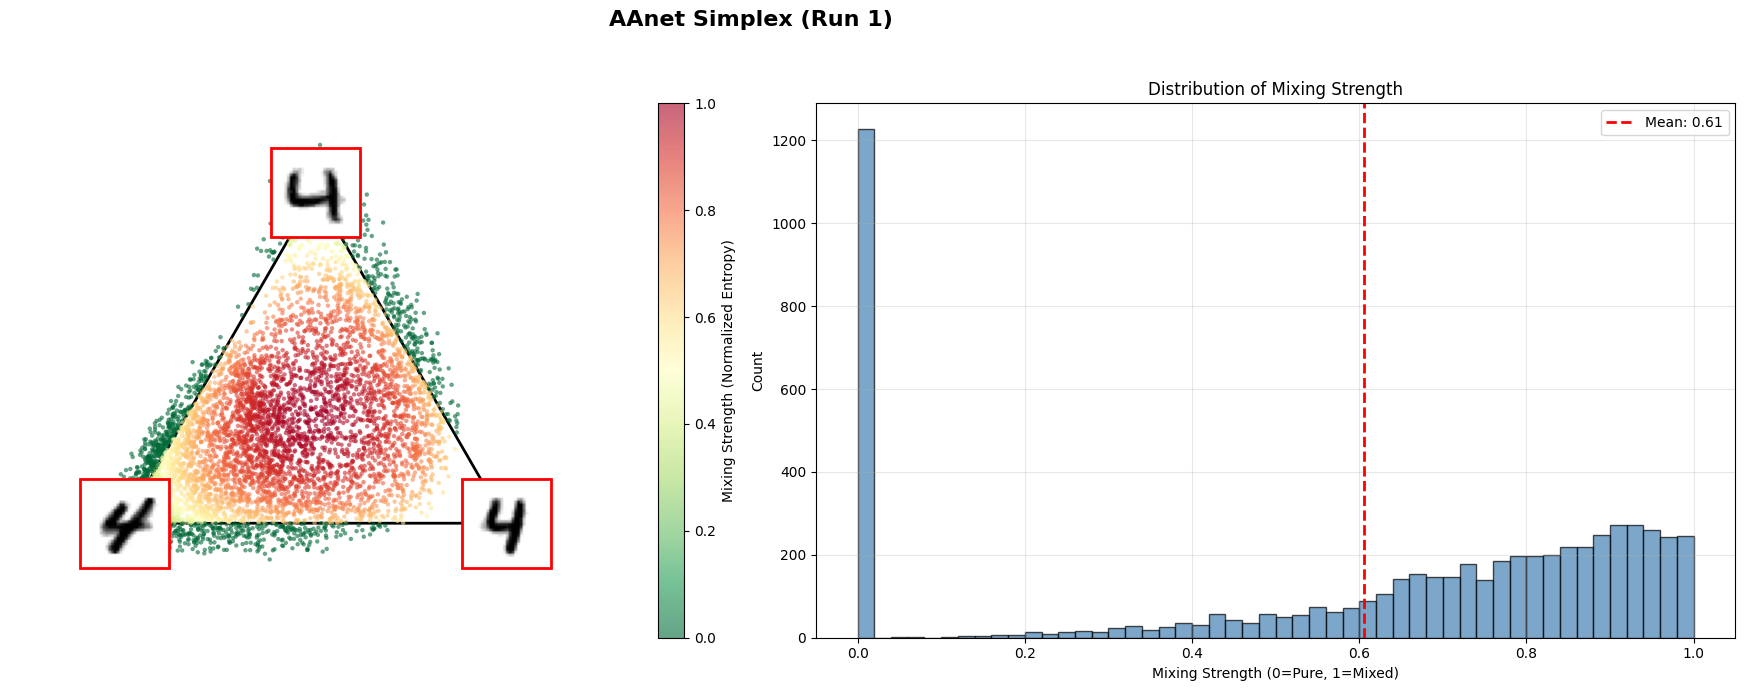

In [12]:
# Plot archetypes, UMAP assignment, reconstruction, and simplex for both Linear AA and AAnet (first run)

X_umap = umap.UMAP(n_neighbors=30, min_dist=0.3, random_state=42).fit_transform(X_raw)


# --- Linear AA (already shown above, but for clarity) ---
plot_archetypes(
    C_list[0],
    title="Linear AA Archetypes (Run 1)",
    save_name=os.path.join(SAVE_DIR, "linear_aa_archetypes_run1.png")
)

plot_umap_assignment(
    X_umap,
    S_linear,
    title="Linear AA Sample Assignment (Run 1)",
    save_name=os.path.join(SAVE_DIR, "linear_aa_umap_run1.png")
)

plot_reconstruction(
    X_raw,
    C_list[0],  # Use correctly shaped archetypes (784, 3)
    S_linear,
    title="Linear AA Reconstruction (Run 1)",
    save_name=os.path.join(SAVE_DIR, "linear_aa_reconstruction_run1.png")
)

plot_simplex(
    S_linear,
    C_list[0],  # Use correctly shaped archetypes (784, 3)
    title="Linear AA Simplex (Run 1)",
    save_name=os.path.join(SAVE_DIR, "linear_aa_simplex_run1.png")
)

# --- AAnet (first run) ---
plot_archetypes(
    C_aanet,
    title="AAnet Archetypes (Run 1)",
    save_name=os.path.join(SAVE_DIR, "aanet_archetypes_run1.png")
)

plot_umap_assignment(
    X_umap,
    S_aanet,
    title="AAnet Sample Assignment (Run 1)",
    save_name=os.path.join(SAVE_DIR, "aanet_umap_run1.png")
)

plot_reconstruction(
    X_raw,
    C_aanet,
    S_aanet,
    title="AAnet Reconstruction (Run 1)",
    save_name=os.path.join(SAVE_DIR, "aanet_reconstruction_run1.png")
)

plot_simplex(
    S_aanet,
    C_aanet,
    title="AAnet Simplex (Run 1)",
    save_name=os.path.join(SAVE_DIR, "aanet_simplex_run1.png")
)

